In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

Our data set is composed of two columns: the name  of a Brazilian Jiu Jitsu competitor and a list of dictionaries where each dictionary represents a match.

In [2]:
df = pd.read_json('bjjheroes_matches.json')
df.head(5)

,matches,name
0,"[{'method': 'Inside heel hook', 'outcome': 'L'...",Aaron Johnson
1,"[{'method': 'Referee Decision', 'outcome': 'L'...",Abdurakhman Bilarov
2,"[{'method': 'Adv', 'outcome': 'L', 'weight': '...",Abraham Marte
3,"[{'method': 'Referee Decision', 'outcome': 'L'...",Adam Benayoun
4,"[{'method': 'RNC', 'outcome': 'L', 'weight': '...",Adam Ferrara


We can access the list of matches for the first fighter, and while we're at it we can turn that into a data frame too (we'll assign it to the variable df0 because it's the entry at index 0).

In [3]:
print(df.loc[0, 'matches'][:10])
df0 = pd.DataFrame(df.loc[0, 'matches'])
df0.head(10)

[{'method': 'Inside heel hook', 'outcome': 'L', 'weight': 'ABS', 'year': '2015'}, {'method': 'RNC', 'outcome': 'L', 'weight': '94KG', 'year': '2015'}, {'method': 'Heel hook', 'outcome': 'L', 'weight': 'ABS', 'year': '2015'}, {'method': 'Points', 'outcome': 'L', 'weight': '94KG', 'year': '2016'}, {'method': 'N/A', 'outcome': 'L', 'weight': '94KG', 'year': '2016'}, {'method': 'Cross choke', 'outcome': 'L', 'weight': 'HWABS', 'year': '2016'}, {'method': 'Choke', 'outcome': 'L', 'weight': 'ABS', 'year': '2016'}, {'method': 'Triangle', 'outcome': 'L', 'weight': '100KG', 'year': '2016'}, {'method': 'Triangle armbar', 'outcome': 'L', 'weight': 'ABS', 'year': '2016'}, {'method': 'Choke from back', 'outcome': 'L', 'weight': 'ABS', 'year': '2016'}]


,method,outcome,weight,year
0,Inside heel hook,L,ABS,2015
1,RNC,L,94KG,2015
2,Heel hook,L,ABS,2015
3,Points,L,94KG,2016
4,N/A,L,94KG,2016
5,Cross choke,L,HWABS,2016
6,Choke,L,ABS,2016
7,Triangle,L,100KG,2016
8,Triangle armbar,L,ABS,2016
9,Choke from back,L,ABS,2016


I can measure the percentage of wins for this fighter by sorting out all wins and dividing them by the total number of matches. 

In [4]:
wins = df0[df0['outcome'] == 'W']
test_win_percent = len(wins)/len(df0)
print(test_win_percent)

0.5462184873949579


We'll turn this into a function so that we can reuse it for other fighters.

In [5]:
def calculate_win_percent(matches_df):
    wins = matches_df[matches_df['outcome'] == 'W']
    return len(wins)/len(matches_df)
print(calculate_win_percent(df0) == test_win_percent)

True


Now I want to calculate how many wins came by submission vs any other method (Decision, DQ, Points, etc). To do this, I need to figure out what all the possible method labels are and make a list of the non-submission methods so that I can separate those matches out.

In [6]:
all_methods = df0['method'].unique()
all_methods = pd.Series(all_methods)
all_methods

0        Inside heel hook
1                     RNC
2               Heel hook
3                  Points
4                     N/A
5             Cross choke
6                   Choke
7                Triangle
8         Triangle armbar
9         Choke from back
10      Arm in guillotine
11              Pts: 19x0
12              Pts: 10x0
13               Pts: 4x2
14                Botinha
15            Brabo choke
16            Calf slicer
17       Reverse triangle
18               Pts: 2x0
19          Pts: 0x0, Adv
20                     DQ
21               Pts: 7x2
22       Referee Decision
23               Pts: 6x0
24               Pts: 5x0
25              Pts: 34x0
26              Pts: 15x0
27               Pts: 6x1
28              Pts: 11x0
29               Pts: 3x0
30                 EBI/OT
31             Katagatame
32               Toe hold
33    Straight ankle lock
34          Flying armbar
35             Submission
36               Pts: 7x6
37                 Armbar
38          

First we'll use pandas built in regular expressions methods to filter out all the outcomes with the 'Pts' at the begining and set this as our submission_methods series.

In [7]:
submission_methods = all_methods[all_methods.str.match('^Pts.*')== False]
print(len(submission_methods))
print(submission_methods)

32
0        Inside heel hook
1                     RNC
2               Heel hook
3                  Points
4                     N/A
5             Cross choke
6                   Choke
7                Triangle
8         Triangle armbar
9         Choke from back
10      Arm in guillotine
14                Botinha
15            Brabo choke
16            Calf slicer
17       Reverse triangle
20                     DQ
22       Referee Decision
30                 EBI/OT
31             Katagatame
32               Toe hold
33    Straight ankle lock
34          Flying armbar
35             Submission
37                 Armbar
39                Kneebar
40                    Adv
41               Footlock
44                    ---
45          Mounted choke
46                Armlock
47                 Kimura
48    Straignt ankle lock
dtype: object


There are still a lot of non-submission methods left in our submission_methods series, so we'll take a look at what's left and repeat the previous step to filter out each of those. To save time, we can put each regular expressions pattern in parentheses and chain them together with a pipe '|'.

In [8]:
submission_methods = submission_methods[submission_methods.str.match('(^Pts.*)|(.*OT)|(Adv)|(N/A)|(DQ)|(.*Decision)|(--)|(Points)')== False]
print(len(submission_methods))
print(submission_methods)

25
0        Inside heel hook
1                     RNC
2               Heel hook
5             Cross choke
6                   Choke
7                Triangle
8         Triangle armbar
9         Choke from back
10      Arm in guillotine
14                Botinha
15            Brabo choke
16            Calf slicer
17       Reverse triangle
31             Katagatame
32               Toe hold
33    Straight ankle lock
34          Flying armbar
35             Submission
37                 Armbar
39                Kneebar
41               Footlock
45          Mounted choke
46                Armlock
47                 Kimura
48    Straignt ankle lock
dtype: object


Now we need to take our list of wins and filter the 'methods' column the same way we filterd our series of methods above. Because many of the methods work on both pd.Series and pd.DataFrame, we can copy and paste the operations onto our wins\['methods'\] and it will remove any non-submission victories. Then we divide that number by the total number of wins, giving us our win-by-submission rate.

In [9]:
submission_wins = wins[wins['method'].str.match('(^Pts.*)|(.*OT)|(Adv)|(N/A)|(DQ)|(.*Decision)|(--)|(Points)')== False]
test_sub_win_percent = len(submission_wins)/len(wins)
print(test_sub_win_percent)

0.6615384615384615


Now We'll turn this into a function as well.

In [10]:
def calculate_sub_win_percent(matches_df):
    wins = matches_df[matches_df['outcome'] == 'W']
    if len(wins) == 0:
        return 0
    else:
        re_non_sub_methods = '(^Pts.*)|(.*OT)|(Adv)|(N/A)|(DQ)|(.*Decision)|(--)|(Points)'
        submission_wins = wins[wins['method'].str.match(re_non_sub_methods)== False]
    return len(submission_wins)/len(wins)

print(calculate_sub_win_percent(df0) == test_sub_win_percent)

True


Now that I have the first two stats I want to look at, I can create a new dataframe comprised of each fighter and their respective win and sub percentages.

In [11]:
all_names = list(df['name'])
all_win_percents = []
all_sub_win_percents = []
for entry in df['matches']:
    matches_df = pd.DataFrame(entry)
    all_win_percents.append(calculate_win_percent(matches_df))
    all_sub_win_percents.append(calculate_sub_win_percent(matches_df))

new_df = pd.DataFrame({'names':all_names, 
                       'all_win_percents':all_win_percents,
                       'all_sub_win_percents':all_sub_win_percents})
new_df.head()

,names,all_win_percents,all_sub_win_percents
0,Aaron Johnson,0.546218,0.661538
1,Abdurakhman Bilarov,0.687500,0.636364
2,Abraham Marte,0.615385,0.700000
3,Adam Benayoun,0.609756,0.360000
4,Adam Ferrara,0.545455,0.833333


This new dataframe gives a different look at each fighter, and I can visualize this easily with seaborn

,all_win_percents,all_sub_win_percents
all_win_percents,1.000000,0.135998
all_sub_win_percents,0.135998,1.000000


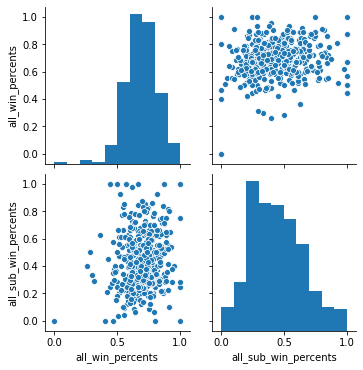

In [12]:
sns.pairplot(new_df)
new_df.corr()